In [30]:
%matplotlib inline
from commonmethods.utility_methods import natural_keys
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import medfilt
from common_classes import SSPFMSignal, EFPFMSignal
from scipy.optimize import leastsq
from itertools import chain
from SSPFM.sspfm import HysteresisProcessor
import scipy.signal as sp_signal
from common_classes import Model
from common_classes import Filtrator, Fitter, Parameters, Measurement
from commonmethods.utility_methods import get_bin_files_in_dir, read_floats
from scipy.signal import medfilt

In [31]:
def arrows(fig, ax):
    ax.tick_params(axis='both',
                   which='both',
                   left=False,
                   right=False,
                   bottom=False,
                   top=False,
                   labelbottom=False,
                   labeltop=False,
                   labelleft=False,
                   labelright=False)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # removing the default axis on all sides:
    for side in ['bottom','right','top','left']:
        ax.spines[side].set_visible(False)

    # get width and height of axes object to compute
    # matching arrowhead length and width
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height

    # manual arrowhead width and length
    hw = 1./20.*(ymax-ymin)
    hl = 1./20.*(xmax-xmin)
    lw = 1. # axis line width
    ohg = 0.3 # arrow overhang

    # compute matching arrowhead length and width
    yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width
    yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

    # draw x and y axis
    ax.arrow(0, 0, xmax-xmin, 0., fc='k', ec='k', lw = lw,
             head_width=hw, head_length=hl, overhang = ohg,
             length_includes_head= True, clip_on = False)

    ax.arrow(0, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw,
             head_width=yhw, head_length=yhl, overhang = ohg,
             length_includes_head= True, clip_on = False)
    

# SSPFM signal

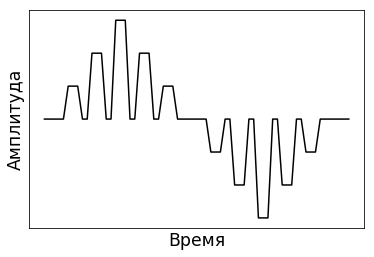

In [26]:
signal = SSPFMSignal(
    #20, 4, 4, 1, 1, 1, 1, False
    3, 3, 2, 1, 1, 1, 1, False
)
figure = plt.figure()
ax = figure.add_subplot(111)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False, labelleft=False)
ax.set_xlabel('Время', size='xx-large')
ax.set_ylabel('Амплитуда', size='xx-large')

ax.plot(np.array(signal.voltage)+1.1, color='black')

#arrows(fig, ax)

#figure.savefig('signal.png')

# BE PFM driving signal

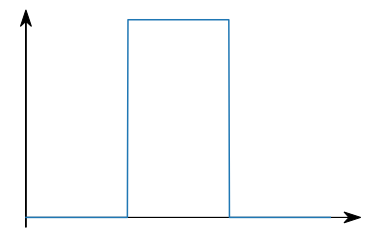

In [27]:
f = np.linspace(0, 1, 500)[:-1]
square = 1-sp_signal.square(2 * np.pi * f * 1.5)
osc = 1+Model.amp_func(f, 0.5, 0.54, 4, -2)
osc_ind = np.where(osc >= 0)

t = np.fft.fftfreq(len(f), f[1] - f[0])
sq_freq = np.real(np.fft.ifft(square))
osc_freq = np.real(np.fft.ifft(osc))
miny = min(sq_freq.min(), osc_freq.min())
#sq_freq -= miny
#osc_freq -= miny
bound = slice(2, -2)
s_ = np.zeros(len(t))
s_[len(t) // 2] = 1

sine_in = np.sin(2*np.pi*t)
sine_out = np.sin(2*np.pi*t*0.8)

fig, axes = plt.subplots(1)

axes.plot(f, square)
#axes.plot(f[osc_ind], osc[osc_ind])
arrows(fig, axes)
#axes[1].plot(t[bound], sq_freq[bound])
#axes[1].plot(t[bound], osc_freq[bound])
#for ax in axes.flatten():
#    print(ax)
#    arrows(fig, ax)

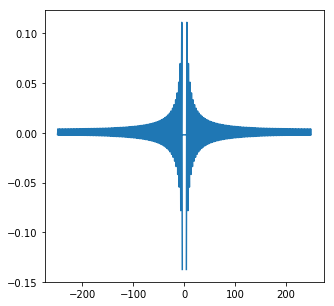

In [28]:
fig, axes = plt.subplots(1, figsize=(5,5))
iii = np.where(sq_freq < 0.15)

axes.plot(t[iii][bound], sq_freq[iii][bound])
#axes.plot(t, osc_freq)
#arrows(fig, axes)

# Fitting and filtration

In [117]:
root = r'C:\Users\ru\Downloads\LaBFO_05_loops\LaBFO_05_loops'
input_dirs = [os.path.join(root, dir_name) for dir_name in sorted(os.listdir(root), key=natural_keys)]
def phase_func(w, w_res, Q):
    return -np.arctan(1/(w*w_res / (Q*(np.square(w) - np.square(w_res)))))
    #return np.arctan((w*w_res / (Q*(np.square(w) - np.square(w_res)))))
dir_index = 500
file_index = 5
filtration_start = 0

input_dir = input_dirs[dir_index]
dir_w_files = os.path.join(input_dir, 'fourier_amp_ph')
parameters = Parameters.read_from_file(os.path.join(input_dir, 'paramiters.txt'))

fitter = Fitter(parameters)
filtrator = Filtrator(filtration_start, parameters.bins_number, filt_window={'amp': 1, 'phase':1})
dir_files = get_bin_files_in_dir(dir_w_files)
filename = dir_files[file_index]

data = Measurement.read_from_file(filename)
meas = filtrator.filter_measurement(data)
fit = fitter.fit(meas)
fitted_amp = fitter.eval_fitted_amp(meas, fit)
fitted_phase = phase_func(meas.freq, fit.w_res, fit.Q)

C:\Users\ru\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


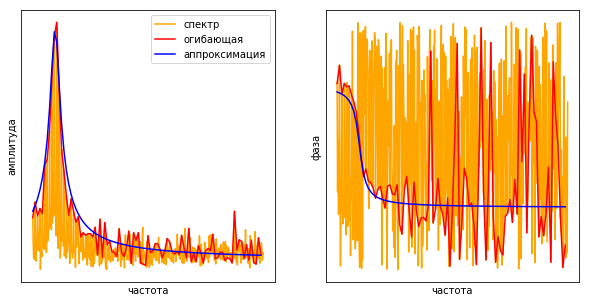

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].set_title
ax[0].plot(data.freq, data.amp,color='orange', label='спектр')
ax[0].plot(meas.freq, meas.amp, color='red', label='огибающая')
ax[0].plot(meas.freq, fitted_amp, color='blue', label='аппроксимация')
ax[0].set_xlabel('частота')
ax[0].set_ylabel('амплитуда')
ax[1].set_xlabel('частота')
ax[1].set_ylabel('фаза')
#ax[1].yaxis.set_label_position('right')
for ax_ in ax:
    ax_.tick_params(axis='both',
                   which='both',
                   left=False,
                   right=False,
                   bottom=False,
                   top=False,
                   labelbottom=False,
                   labeltop=False,
                   labelleft=False,
                   labelright=False)
    #ax_.spines['top'].set_visible(False)
#ax[0].spines['right'].set_visible(False)
#ax[1].spines['left'].set_visible(False)
ax[0].legend()
ax[1].plot(data.freq, data.phase, color='orange')
ax[1].plot(meas.freq, meas.phase, color='red')
ax[1].plot(meas.freq, fitted_phase, color='blue')
fig.savefig('fitting.png')

# EFPFM

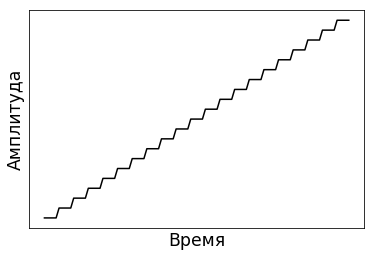

In [139]:
efpfm = EFPFMSignal(
    10, 5, 0, 1, 1, 1, 1, False
)
fig, ax = plt.subplots()
ax.set_xlabel('Время', size='xx-large')
ax.set_ylabel('Амплитуда', size='xx-large')
ax.plot(efpfm.voltage-min(efpfm.voltage), color='black')
#arrows(fig, ax)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False, labelleft=False)
fig.savefig('efpfm_signal.png')